# New York City Taxi Trip Duration
- Share code and data to improve ride time predictions
- https://www.kaggle.com/c/nyc-taxi-trip-duration/data

## Credit to:
- 

In [1]:
# data processing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt
from scipy import stats
from scipy.stats import norm
import math
from numpy import sort

# ML
# # Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, validation_curve, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
# # XGB
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance
# # CatBoost
#from catboost import Pool, CatBoostRegressor, cv, CatboostIpythonWidget
# System
import datetime as dt
from datetime import datetime
import sys
from inspect import getsourcefile
import os.path
import re

# Other
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Input data files are available in the DATA_DIR directory.
DATA_DIR = "data-temp"

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Load data

In [2]:
# Load data. Download from:https://www.kaggle.com/c/bike-sharing-demand/data
train_data = pd.read_csv(DATA_DIR + "/train.csv")
eval_data =  pd.read_csv(DATA_DIR + "/test.csv")

In [4]:
print("train size:", train_data.shape, " test size:", eval_data.shape)

train size: (1458644, 11)  test size: (625134, 9)


In [3]:
train_data.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
eval_data.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [6]:
diff_cols = np.setdiff1d(train_data.columns.values, eval_data.columns.values)
diff_cols

array(['dropoff_datetime', 'trip_duration'], dtype=object)

### Combine train data and eval data

In [62]:
label = 'trip_duration'
features = eval_data.columns.values
target = train_data[label].values
combine_data = pd.concat([train_data[features], eval_data], keys=['train','eval'])
combine_data.head(5)

id  vendor_id      pickup_datetime  passenger_count  \
train 0  id2875421          2  2016-03-14 17:24:55                1   
      1  id2377394          1  2016-06-12 00:43:35                1   
      2  id3858529          2  2016-01-19 11:35:24                1   
      3  id3504673          2  2016-04-06 19:32:31                1   
      4  id2181028          2  2016-03-26 13:30:55                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
train 0        -73.982155        40.767937         -73.964630   
      1        -73.980415        40.738564         -73.999481   
      2        -73.979027        40.763939         -74.005333   
      3        -74.010040        40.719971         -74.012268   
      4        -73.973053        40.793209         -73.972923   

         dropoff_latitude store_and_fwd_flag  
train 0         40.765602                  N  
      1         40.731152                  N  
      2         40.710087                  N  
      3         40.706718                  N  
      4         40.782520                  N

# Pre-process data

### Check NaN columns

In [8]:
def check_null_data(data):
    #Get high percent of NaN data
    null_data = combine_data.isnull()
    total = null_data.sum().sort_values(ascending=False)
    percent = (null_data.sum()/null_data.count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    high_percent_miss_data = missing_data[missing_data['Percent']>0]
    #print(missing_data)
    print(high_percent_miss_data)
    miss_data_cols = high_percent_miss_data.index.values
    return miss_data_cols

In [9]:
# Check target for null
check_null_data(target)

Empty DataFrame
Columns: [Total, Percent]
Index: []


array([], dtype=object)

In [10]:
# combine data for null
check_null_data(combine_data)

Empty DataFrame
Columns: [Total, Percent]
Index: []


array([], dtype=object)

In [11]:
combine_data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
dtype: object

# Transform object data

In [63]:
data = combine_data

### Convert datetime string to object

In [17]:
def pd_datetime(data):
    date_format = "%Y-%m-%d %H:%M:%S"
    datetime_obj = data['pickup_datetime'].apply(lambda x: datetime.strptime(x, date_format))
    return datetime_obj 

In [64]:
data['datetime_obj'] = pd_datetime(data)
data['datetime_obj'][:5]

train  0   2016-03-14 17:24:55
       1   2016-06-12 00:43:35
       2   2016-01-19 11:35:24
       3   2016-04-06 19:32:31
       4   2016-03-26 13:30:55
Name: datetime_obj, dtype: datetime64[ns]

In [65]:
data['pickup_year'] = data['datetime_obj'].apply(lambda x: x.year)
data['pickup_month'] = data['datetime_obj'].apply(lambda x: x.month)
data['pickup_day'] = data['datetime_obj'].apply(lambda x: x.day)
data['pickup_hour'] = data['datetime_obj'].apply(lambda x: x.hour)
data['pickup_weekday'] = data['datetime_obj'].apply(lambda x: x.weekday())
data[:5]

id  vendor_id      pickup_datetime  passenger_count  \
train 0  id2875421          2  2016-03-14 17:24:55                1   
      1  id2377394          1  2016-06-12 00:43:35                1   
      2  id3858529          2  2016-01-19 11:35:24                1   
      3  id3504673          2  2016-04-06 19:32:31                1   
      4  id2181028          2  2016-03-26 13:30:55                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
train 0        -73.982155        40.767937         -73.964630   
      1        -73.980415        40.738564         -73.999481   
      2        -73.979027        40.763939         -74.005333   
      3        -74.010040        40.719971         -74.012268   
      4        -73.973053        40.793209         -73.972923   

         dropoff_latitude store_and_fwd_flag        datetime_obj  pickup_year  \
train 0         40.765602                  N 2016-03-14 17:24:55         2016   
      1         40.731152                  N 2016-06-12 00:43:35         2016   
      2         40.710087                  N 2016-01-19 11:35:24         2016   
      3         40.706718                  N 2016-04-06 19:32:31         2016   
      4         40.782520                  N 2016-03-26 13:30:55         2016   

         pickup_month  pickup_day  pickup_hour  pickup_weekday  
train 0             3          14           17               0  
      1             6          12            0               6  
      2             1          19           11               1  
      3             4           6           19               2  
      4             3          26           13               5

### store_and_fwd_flag

In [66]:
col = 'store_and_fwd_flag'
data[col].value_counts()

N    2072303
Y      11475
Name: store_and_fwd_flag, dtype: int64

In [67]:
data_dict = {'Y':1, 'N':0}
data_tf = data[col].map(data_dict)
data[col].update(data_tf)
data[:5]

id  vendor_id      pickup_datetime  passenger_count  \
train 0  id2875421          2  2016-03-14 17:24:55                1   
      1  id2377394          1  2016-06-12 00:43:35                1   
      2  id3858529          2  2016-01-19 11:35:24                1   
      3  id3504673          2  2016-04-06 19:32:31                1   
      4  id2181028          2  2016-03-26 13:30:55                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
train 0        -73.982155        40.767937         -73.964630   
      1        -73.980415        40.738564         -73.999481   
      2        -73.979027        40.763939         -74.005333   
      3        -74.010040        40.719971         -74.012268   
      4        -73.973053        40.793209         -73.972923   

         dropoff_latitude store_and_fwd_flag        datetime_obj  pickup_year  \
train 0         40.765602                  0 2016-03-14 17:24:55         2016   
      1         40.731152                  0 2016-06-12 00:43:35         2016   
      2         40.710087                  0 2016-01-19 11:35:24         2016   
      3         40.706718                  0 2016-04-06 19:32:31         2016   
      4         40.782520                  0 2016-03-26 13:30:55         2016   

         pickup_month  pickup_day  pickup_hour  pickup_weekday  
train 0             3          14           17               0  
      1             6          12            0               6  
      2             1          19           11               1  
      3             4           6           19               2  
      4             3          26           13               5

### Drop unused cols

In [68]:
data.drop('id', axis=1, inplace=True)

In [69]:
# Drop pickup_datetime
data.drop('pickup_datetime', axis=1, inplace=True)
data.drop('datetime_obj', axis=1, inplace=True)

In [70]:
combine_data_tf = data

# Exploring data

### Split train_set and eval_set

In [71]:
data = combine_data_tf
train_set = data.loc['train']
eval_set = data.loc['eval']
data = train_set.copy()
data[label] = target
data[:5]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_weekday,trip_duration
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,2016,3,14,17,0,455
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,2016,6,12,0,6,663
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,2016,1,19,11,1,2124
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,2016,4,6,19,2,429
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,2016,3,26,13,5,435


### Label distribution

In [29]:
data[label].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

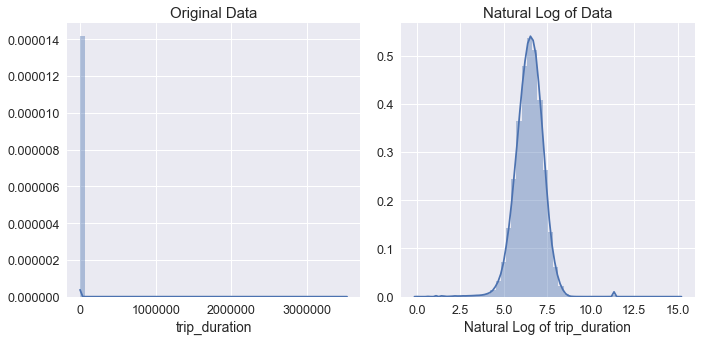

In [72]:
target_log = np.log(target)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(target, bins=50)
plt.title('Original Data')
plt.xlabel(label)

plt.subplot(1,2,2)
sns.distplot(target_log, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of ' + label)
plt.tight_layout()

### Feature correlation

In [57]:
correlation = data.corr()[label].sort_values()[-20:]
correlation

pickup_latitude     -0.029204
dropoff_latitude    -0.020677
pickup_weekday      -0.000708
pickup_day           0.000566
pickup_hour          0.003690
pickup_month         0.006607
passenger_count      0.008471
dropoff_longitude    0.014678
vendor_id            0.020304
pickup_longitude     0.026542
trip_duration        1.000000
pickup_year               NaN
Name: trip_duration, dtype: float64

['trip_duration' 'pickup_longitude' 'vendor_id' 'dropoff_longitude'
 'passenger_count' 'pickup_month' 'pickup_hour' 'pickup_day'
 'pickup_weekday' 'dropoff_latitude' 'pickup_latitude']


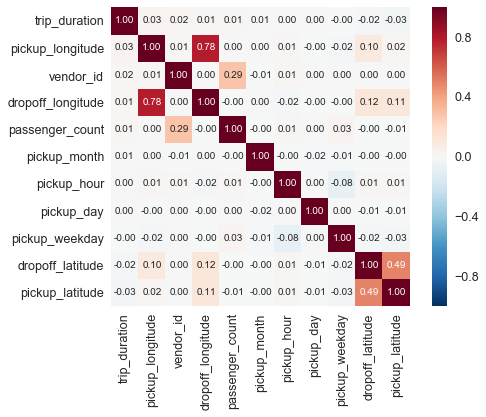

In [58]:
#correlation matrix
corrmat = data.corr()
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, label)[label].index
print(cols.values)
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

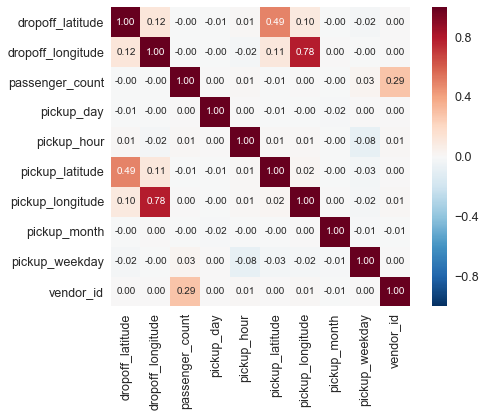

In [59]:
# Correlation matrix of cols except label
other_cols = np.setdiff1d(cols.values, label)
cm = np.corrcoef(data[other_cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=other_cols, xticklabels=other_cols)
plt.show()

# Feature engineering

In [61]:
data_fe = train_set.copy()
data_fe[label] =target_log
data_fe[:5]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,datetime_obj,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_weekday,trip_duration
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,2016-03-14 17:24:55,2016,3,14,17,0,6.120297
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,2016-06-12 00:43:35,2016,6,12,0,6,6.496775
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,2016-01-19 11:35:24,2016,1,19,11,1,7.661056
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,2016-04-06 19:32:31,2016,4,6,19,2,6.061457
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,2016-03-26 13:30:55,2016,3,26,13,5,6.075346


# Train model

In [73]:
data = train_set.astype(float)
data[:5]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_weekday
0,2.0,1.0,-73.982155,40.767937,-73.964630,40.765602,0.0,2016.0,3.0,14.0,17.0,0.0
1,1.0,1.0,-73.980415,40.738564,-73.999481,40.731152,0.0,2016.0,6.0,12.0,0.0,6.0
2,2.0,1.0,-73.979027,40.763939,-74.005333,40.710087,0.0,2016.0,1.0,19.0,11.0,1.0
3,2.0,1.0,-74.010040,40.719971,-74.012268,40.706718,0.0,2016.0,4.0,6.0,19.0,2.0
4,2.0,1.0,-73.973053,40.793209,-73.972923,40.782520,0.0,2016.0,3.0,26.0,13.0,5.0


## Model definition & training

In [75]:
# A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
# credit: https://www.kaggle.com/marknagelberg/rmsle-function
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(math.fabs(y_pred[i]) + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    #for i, pred in enumerate(y_pred):
    #    print("i:", i, " pred:", y_pred[i])
    #    print(math.log(y_pred[i] + 1))
    #    print(math.log(y[i] + 1))
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [76]:
#model = CatBoostRegressor(iterations=100, depth=5, thread_count=4, use_best_model=True)
model = XGBRegressor(n_estimators=1000, max_depth=5, n_jobs = -1)

### Find the best hyperparam for model using GridSearchCV

In [244]:
param_grid = {"max_depth"         : [1,5,10],
              'learning_rate'     :[0.1, 0.03, 0.01],
              'min_child_weight':  [1, 2, 5, 10]
             }
grid_search = GridSearchCV(model, param_grid, n_jobs=1, cv=5)
grid_search.fit(data, target_log)
print(grid_search.best_params_)

{'max_depth': 5, 'min_child_weight': 5, 'learning_rate': 0.03}


### Tuning param after GridSearchCV

In [245]:
model.set_params(**grid_search.best_params_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=490,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Cross validate

In [77]:
dtrain = xgb.DMatrix(data,label=target_log, feature_names=data.columns.values)
params = model.get_xgb_params()
cvresults = xgb.cv(params, dtrain, num_boost_round=2000, nfold=5, early_stopping_rounds=50, verbose_eval=50)

[0]	train-rmse:5.42416+0.000240428	test-rmse:5.42417+0.00111489
[50]	train-rmse:0.582214+0.00284916	test-rmse:0.583054+0.00106714
[100]	train-rmse:0.519441+0.00268402	test-rmse:0.521049+0.00299177
[150]	train-rmse:0.491279+0.0026057	test-rmse:0.493464+0.00173314
[200]	train-rmse:0.475583+0.00282841	test-rmse:0.478217+0.00102762
[250]	train-rmse:0.466637+0.00279359	test-rmse:0.469789+0.00119378
[300]	train-rmse:0.45853+0.00188917	test-rmse:0.462134+0.00226137
[350]	train-rmse:0.452665+0.00179359	test-rmse:0.45669+0.00265356
[400]	train-rmse:0.448441+0.00164313	test-rmse:0.452915+0.00258443
[450]	train-rmse:0.445175+0.000944488	test-rmse:0.45005+0.00331796
[500]	train-rmse:0.441755+0.00121731	test-rmse:0.447085+0.00319737
[550]	train-rmse:0.43849+0.00115498	test-rmse:0.444158+0.00265933
[600]	train-rmse:0.436216+0.000922203	test-rmse:0.442291+0.00286208
[650]	train-rmse:0.434434+0.00103826	test-rmse:0.440842+0.00291359


KeyboardInterrupt: 

In [249]:
print(cvresults.shape[0])
print(cvresults[-5:])
#print(cvresults.index.values)

1597
      test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
1592        0.306424       0.007565         0.202305        0.002672
1593        0.306413       0.007556         0.202267        0.002678
1594        0.306400       0.007572         0.202232        0.002664
1595        0.306407       0.007571         0.202207        0.002685
1596        0.306397       0.007583         0.202165        0.002690


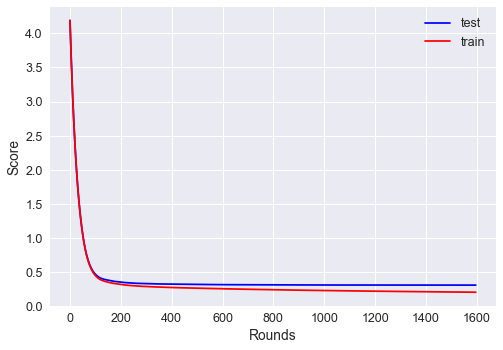

In [250]:
# plot cross validate
plt.plot(cvresults.index.values, cvresults['test-rmse-mean'], c='b', label='test')
plt.plot(cvresults.index.values, cvresults['train-rmse-mean'], c='r', label='train')
plt.xlabel('Rounds')
plt.ylabel('Score')
plt.legend()
plt.show()


### Tuning param after CV

In [251]:
model.set_params(n_estimators=cvresults.shape[0])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=1597,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Plot learning curve to determine best train/test split

In [208]:
def plot_learning_curve(X, Y):
    plt.figure(figsize=(20,10))
    plt.title("Learing curve")
    # if ylim is not None:
    #     plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(model, X, Y)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

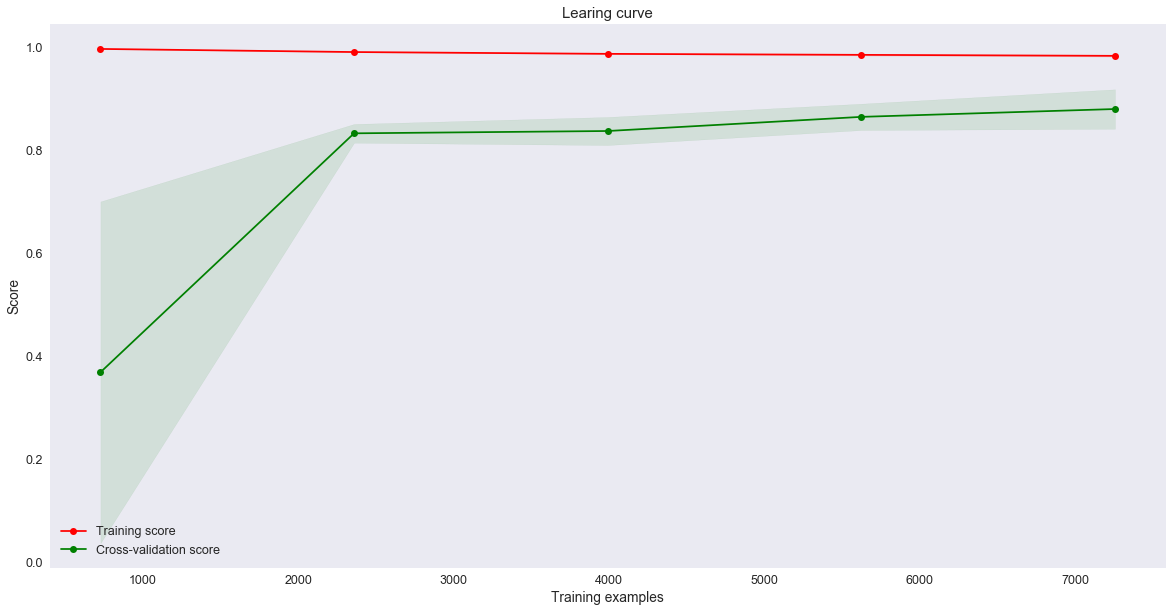

In [252]:
plot_learning_curve(data, target_log)

### Split train/test set

In [253]:
X_train, X_test, Y_train, Y_test = train_test_split(data, target_log, train_size=0.85, random_state=1234)
print("X_train:", X_train.shape, " Y_train:", Y_train.shape, " X_test:", X_test.shape, " Y_test:", Y_test.shape)
X_train[:5]

X_train: (9253, 13)  Y_train: (9253,)  X_test: (1633, 13)  Y_test: (1633,)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday
7973,2.0,0.0,1.0,3.0,26.24,28.790,89.0,16.9979,2012.0,6.0,12.0,14.0,1.0
2514,2.0,0.0,0.0,3.0,27.88,31.820,83.0,19.0012,2011.0,6.0,12.0,16.0,6.0
8668,3.0,0.0,1.0,2.0,35.26,40.150,47.0,19.0012,2012.0,8.0,3.0,13.0,4.0
9173,3.0,0.0,1.0,1.0,33.62,39.395,56.0,7.0015,2012.0,9.0,5.0,14.0,2.0
4822,4.0,0.0,1.0,1.0,18.86,22.725,59.0,19.0012,2011.0,11.0,14.0,0.0,0.0


### Train data

In [254]:
model.fit(
    X_train, Y_train,   
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=1597,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Predict for test data

In [255]:
y_pred = model.predict(X_test)

In [256]:
# Evaluate score
print(y_pred[:5])
score = rmsle(Y_test, y_pred)
print("RMSLE score:", score)

[ 5.34161806  4.41765404  4.53936005  1.61217463  5.77588844]
RMSLE score: 0.1082141854376401


### Feature importances

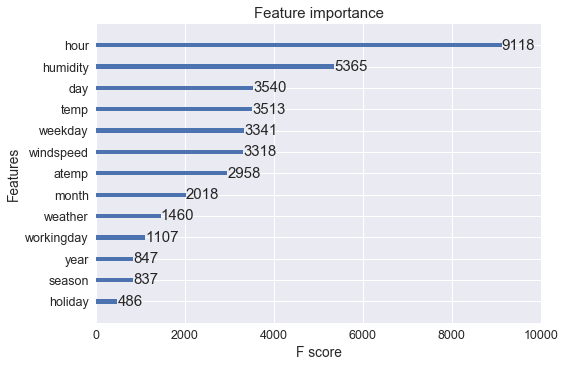

In [257]:
plot_importance(model)
plt.show()

In [188]:
model_params = model.get_params()
model_params

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 567,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [189]:
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    #print("X_train:", X_train.shape, " X_test:", X_test.shape)
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBRegressor()
    selection_model.set_params(**model_params)
    selection_model.fit(select_X_train, Y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    score = rmsle(Y_test, y_pred)
    print("Thresh=%.3f, n=%d, Score: %.2f%%" % (thresh, select_X_train.shape[1], score))

Thresh=0.007, n=14, Score: 0.12%
Thresh=0.010, n=13, Score: 0.12%
Thresh=0.013, n=12, Score: 0.12%
Thresh=0.014, n=11, Score: 0.11%
Thresh=0.019, n=10, Score: 0.11%
Thresh=0.038, n=9, Score: 0.12%
Thresh=0.045, n=8, Score: 0.12%
Thresh=0.049, n=7, Score: 0.16%
Thresh=0.075, n=6, Score: 0.16%
Thresh=0.108, n=5, Score: 0.16%
Thresh=0.123, n=4, Score: 0.17%
Thresh=0.128, n=3, Score: 0.17%
Thresh=0.170, n=2, Score: 0.20%
Thresh=0.202, n=1, Score: 0.28%


# Predict and save submission

In [258]:
data = eval_set.drop('datetime_obj', axis=1).astype(float)
Y_eval_log = model.predict(data)
Y_eval = np.exp(Y_eval_log.ravel())
print(Y_eval_log[:5])
print(Y_eval[:5])

[ 2.30123353  1.44256282  1.07916021  0.65330034  0.49184653]
[ 9.98649311  4.23152637  2.94220757  1.92187321  1.63533318]


In [259]:
eval_output = pd.DataFrame({'datetime': eval_data['datetime'], 'count': Y_eval})
print(len(eval_output))
eval_output.head()

6493


,count,datetime
0,9.986493,2011-01-20 00:00:00
1,4.231526,2011-01-20 01:00:00
2,2.942208,2011-01-20 02:00:00
3,1.921873,2011-01-20 03:00:00
4,1.635333,2011-01-20 04:00:00


In [260]:
today = str(dt.date.today())
print(today)
eval_output.to_csv(DATA_DIR +'/' +today+'-submission.csv',index=False)

2017-07-21
